In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [2]:
from io_utils import load_matrices_from_dir, load_models
from scipy.sparse.linalg import norm

  Activating project at `~/My_Drive/Research/code/Dynamic-Selective-Protection/Pcg`
[ Info: Precompiling Pcg [8ffc3672-ba62-4f90-bc1c-a10ffeb4b937]


In [3]:
chosen_mat = "bcsstk18"
chosen_model = "./models/bcsstk18/best_KNeighborsRegressor_2024_01_09-02_23_36_PM.pkl"
# chosen_mat = "cbuckle"
# chosen_model = "./models/cbuckle/best_KNeighborsRegressor_2024_01_09-02_10_49_PM.pkl"
errorfree_iterations = 432

In [4]:
mats = load_matrices_from_dir("../matrices/raw", subset=[chosen_mat])
mat = list(mats.values())[0]
mat

<11948x11948 sparse matrix of type '<class 'numpy.float64'>'
	with 149090 stored elements in Compressed Sparse Column format>

In [5]:
model = load_models([chosen_model])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=4, p=1.0))])

In [6]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                              for i in range(errorfree_iterations)])
df = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df["output"] = model.predict(df[["i", "2norm"]].to_numpy())
df.head()

,i,2norm,rowid,output
0,0.0,7.366534e+06,0.0,1.238426
1,1.0,7.366534e+06,0.0,1.238426
2,2.0,7.366534e+06,0.0,1.238426
3,3.0,7.366534e+06,0.0,1.238426
4,4.0,7.366534e+06,0.0,1.232060


In [7]:
df_piv = df.pivot(index=["2norm", "rowid"], columns="i", values="output")

protections = df_piv.to_numpy()
print(protections.shape, mat.shape, 11948 * 432)
df_piv.head()

(11948, 432) (11948, 11948) 5161536


i              0.0      1.0      2.0      3.0      4.0       5.0       6.0    \
2norm rowid                                                                    
1.0   18.0   1.06713  1.06713  1.06713  1.06713  1.10706  1.063079  1.063079   
      19.0   1.06713  1.06713  1.06713  1.06713  1.10706  1.063079  1.063079   
      20.0   1.06713  1.06713  1.06713  1.06713  1.10706  1.063079  1.063079   
      22.0   1.06713  1.06713  1.06713  1.06713  1.10706  1.063079  1.063079   
      24.0   1.06713  1.06713  1.06713  1.06713  1.10706  1.063079  1.063079   

i               7.0       8.0       9.0    ...     422.0     423.0     424.0  \
2norm rowid                                ...                                 
1.0   18.0   1.064236  1.065394  1.081019  ...  0.989583  0.996528  0.992477   
      19.0   1.064236  1.065394  1.081019  ...  0.989583  0.996528  0.992477   
      20.0   1.064236  1.065394  1.081019  ...  0.989583  0.996528  0.992477   
      22.0   1.064236  1.065394  1.081019  ...  0.989583  0.996528  0.992477   
      24.0   1.064236  1.065394  1.081019  ...  0.989583  0.996528  0.992477   

i               425.0     426.0     427.0     428.0     429.0     430.0  \
2norm rowid                                                               
1.0   18.0   0.992477  0.990162  0.990162  0.997106  0.997106  0.997106   
      19.0   0.992477  0.990162  0.990162  0.997106  0.997106  0.997106   
      20.0   0.992477  0.990162  0.990162  0.997106  0.997106  0.997106   
      22.0   0.992477  0.990162  0.990162  0.997106  0.997106  0.997106   
      24.0   0.992477  0.990162  0.990162  0.997106  0.997106  0.997106   

i               431.0  
2norm rowid            
1.0   18.0   1.005787  
      19.0   1.005787  
      20.0   1.005787  
      22.0   1.005787  
      24.0   1.005787  

[5 rows x 432 columns]

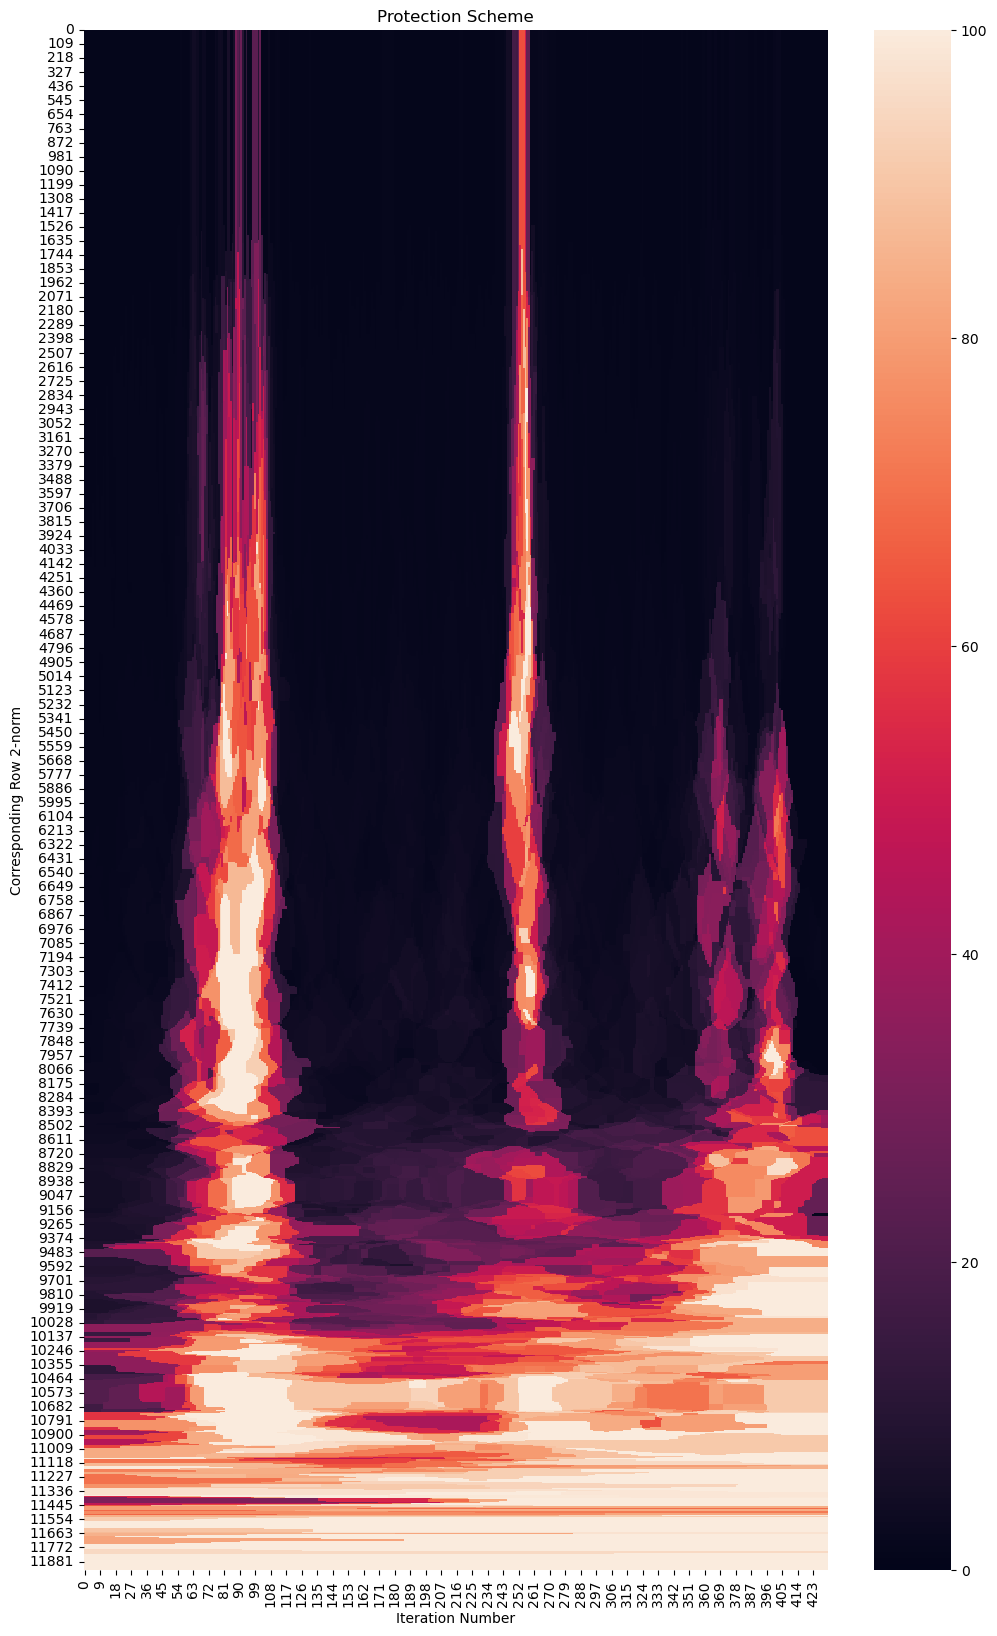

In [8]:
plt.gcf().set_size_inches(12, 20)
plt.gcf().set_dpi(100)
heatmap(protections, vmin=0, vmax=100)
plt.title("Protection Scheme")
plt.xlabel("Iteration Number")
plt.ylabel("Corresponding Row 2-norm")
plt.savefig(f"./figures/{chosen_mat}/prot_scheme.png")
plt.show()